# Part 1 Analysis and Visualization

Business Understanding: The purpose of this project is to use Stack Overflow data from 2020 to better understand:

1. Which programming languages are the most desired next year (Which language to learn in 2021)?
2. Which programming languages are the most popular among developers in 2020?
3. How much more do developers earn for mastering certain programming languages?

In [1]:
# importing the relevant libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Data Understanding: The main data source is the survey results from Stack Overflow which is an open source and can be access through the link in the Readme file. 

In [2]:
#importing the data
df = pd.read_csv("survey_results_public.csv")
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [3]:
#getting an overview of the numerical data in the dataset 
df.describe()

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,CodeRevHrs,Age
count,88883.000000,5.594500e+04,5.582300e+04,64503.000000,49790.000000,79210.000000
mean,44442.000000,5.519014e+11,1.271107e+05,42.127197,5.084308,30.336699
std,25658.456325,7.331926e+13,2.841523e+05,37.287610,5.513931,9.178390
min,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000
25%,22221.500000,2.000000e+04,2.577750e+04,40.000000,2.000000,24.000000
50%,44442.000000,6.200000e+04,5.728700e+04,40.000000,4.000000,29.000000
75%,66662.500000,1.200000e+05,1.000000e+05,44.750000,6.000000,35.000000
max,88883.000000,1.000000e+16,2.000000e+06,4850.000000,99.000000,99.000000


In [4]:
def impute_func(col):
    '''
    INPUT:
    col - column name that needs to be imputed. 
    OUTPUT:
    columns are imputed with the mean of the column values.
    
    Imputes the input columns with the mean of the column values for the relevant variables. As the edge cases in these categories
    are quite small compared to the overrall sample size, the edge numbers are used as imputation numbers. For example, 
    'Less than 1 year' is replaced with nubmer 1.
    '''
    if col == 'YearsCode' or col == 'YearsCodePro':
        df[col] = np.where((df[col] == 'Less than 1 year'),1,df[col])
        df[col] = np.where((df[col] == 'More than 50 years'),50,df[col])
    else:
        df[col] = np.where((df[col] == 'Younger than 5 years'),5,df[col])
        df[col] = np.where((df[col] == 'Older than 85'),85,df[col])

In [5]:
def make_graphs(col_name):
    '''
    INPUT:
    col_name - column name that is used to produce the graphs.  
    OUTPUT:
    Produces graphs based on the input column. 
    
    The function creates the horizontal bar chart for the top ranked programming languages based on their popularity among developers
    '''
    language_ranks = df[col_name].str.split(';', expand=True).stack().value_counts()
    df_language_ranks = pd.DataFrame({'Language':language_ranks.index, 'Frequency':language_ranks.values}).sort_values('Frequency')
    ax = df_language_ranks.plot(x='Language',y='Frequency',kind='barh',figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)
    ax.set_xlabel("Popularity", labelpad=20, weight='bold', size=12)
    ax.set_ylabel("Languages", labelpad=20, weight='bold', size=12)
    if col_name == 'LanguageDesireNextYear':
        ax.set_title("Most Desired Programming Languages in 2021", weight='bold', size=14)
    else:
        ax.set_title("Most Popular Programming Languages in 2020", weight='bold', size=14)
    ax.get_legend().remove()
    fig = ax.get_figure()
    fig.savefig(f'{col_name}.png');

Data Preparation: As there are columns which are mixed of string and float datatypes, this first needs to be imputed using the imputation function defined above. This enables us to have more quantitative data from the dataset. Furthermore, there are missing values in some of the relevant variables which also need to be preprocessed before we can continue with the analysis.

In [6]:
#imputing the YearsCode,Age1stCode,YearsCodePro columns as the values are mixed of float and string data types, the impute_func
#cleans the columns so they can be used for analysis later 
impute_func('YearsCode')
impute_func('Age1stCode')
impute_func('YearsCodePro')

In [7]:
##dealing with null values and removing rows where there are no values for the compensation columns
df.dropna(axis=0,subset=['ConvertedComp'],how='any',inplace = True)
df = df.astype({"YearsCode": float, "Age1stCode": float, "YearsCodePro": float}).drop('CompTotal',axis=1)
df_numerical = df.select_dtypes(include=['float64']).copy()
##replacing  the null values in the numerical columns with the mean of the columns 
for col in df_numerical.columns:
    df_numerical[col].fillna(df_numerical[col].mean(),inplace=True)

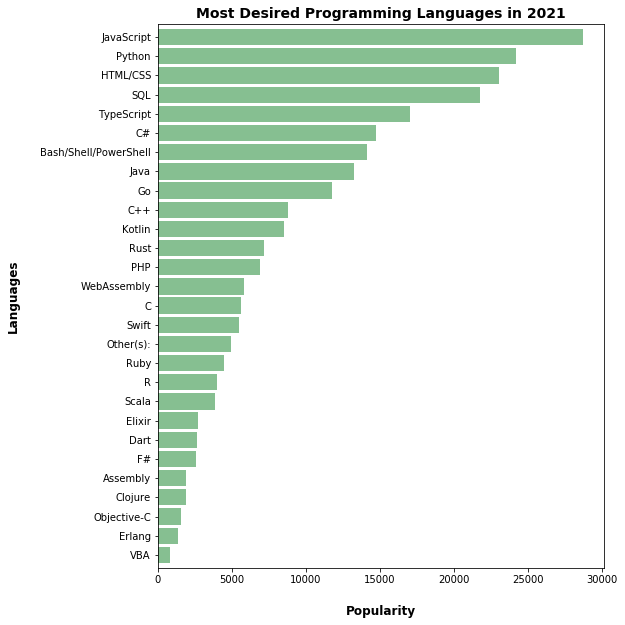

In [8]:
#plotting the graph for the most desired programming languages in 2021
make_graphs('LanguageDesireNextYear')

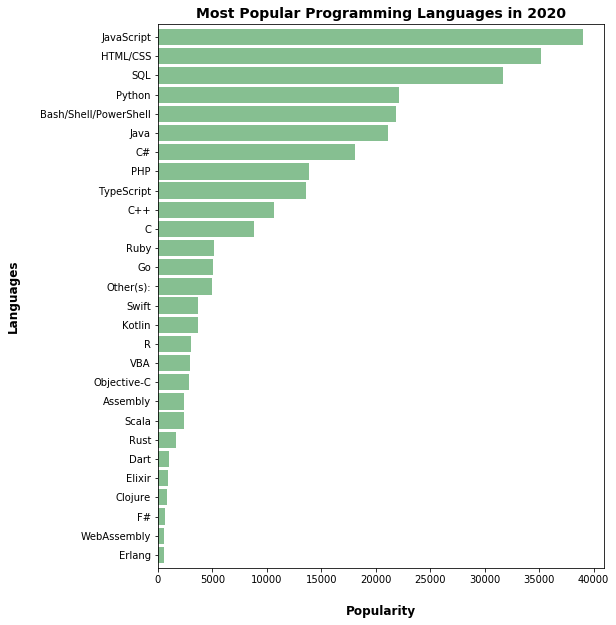

In [9]:
#plotting the graph for the most desired programming languages in 2020
make_graphs('LanguageWorkedWith')

# Part 2 Regression

Modelling: The second part of this project focuses on using a simple linear regression model to evaluate the third question that needs to be addressed which is that how much more can developers earn for mastering certain programming languages. The data will be fitted on the model and used to derive the coefficients to draw the conclusions.

In [10]:
def get_languages(df):
    '''
    INPUT:
    df - the original dataframe is passed in as input.  
    OUTPUT:
    Outputs all the dummy variables for all the programming languages in the answers.
    
    This function takes in the original dataframe and calculates 1 if a developer konws a particular programming language
    and 0 otherwise for that language. Finally the dataframe with dummy variables is returned as output.

    '''
    df = df.copy()
    df.dropna(axis=0,subset=['LanguageWorkedWith'],how='any',inplace = True)
    language_ranks = df['LanguageWorkedWith'].str.split(';', expand=True).stack().value_counts()
    languages = list(language_ranks.index)
    df['NumberofLanguages'] = df['LanguageWorkedWith'].str.split(';').apply(len)
    for language in languages:
        df[f'Knows_{language}'] = np.where(df['LanguageWorkedWith'].str.find(language) != -1,1,0)
    cols = [col for col in df.columns if 'Knows' in col]  
    cols.extend(['NumberofLanguages','ConvertedComp'])
    return df[cols] 

In [11]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


Evaluation: Lastly the cofficients of the variables are ranked based on the size of their absolute values to give an interpretation of their impact on the salary level of the developers. 

In [12]:
#Dividing the dataset into test and training sets, fitting the model and finally predict the results
df_final = get_languages(df)
X = df_final.drop('ConvertedComp',axis=1)
y = df_final['ConvertedComp']
lm_model = LinearRegression(normalize=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
lm_model.fit(X_train,y_train)
y_preds = lm_model.predict(X_test)

#Use the function to plot top variables based on coefficients
coef_df = coef_weights(lm_model.coef_, X_train)
#A quick look at the top results
coef_df.head(5).reset_index().drop('index',axis=1)

,est_int,coefs,abs_coefs
0,Knows_Clojure,52529.070922,52529.070922
1,Knows_F#,49867.943673,49867.943673
2,Knows_Go,40336.980654,40336.980654
3,Knows_Bash/Shell/PowerShell,33824.375640,33824.375640
4,Knows_Scala,33436.851439,33436.851439


Deployment: This notebook serves as the technical foundation for the Medium post that gives a high-level explanation of the findings. The Medium post can be accessed via the link in the Readme section. 